Deal with unlabeled bbox (remove car IDs)
Goal: associate measurements to unique objects
1. try stitching objects in mutl-camera road

In [41]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import data_association as da
importlib.reload(da)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA
from shapely.geometry import Polygon

In [42]:
# read & rectify each camera df individually

data_path = pathlib.Path().absolute().joinpath('../June_5min')
tform_path = pathlib.Path().absolute().joinpath('../tform')


In [43]:
DA_path = data_path.joinpath('DA')
DA_files = next(os.walk(DA_path), (None, None, []))[2] 
rectified_files = next(os.walk(data_path.joinpath('rectified')), (None, None, []))[2]

for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv") and file.startswith('p1c2_2'):
            
#             if file[5]=='0':
            print(file)
            # ... reading & preprocessing ...
            DA_file = 'DA_' + file

            if DA_file not in DA_files:
                file_path = data_path.joinpath(file)
                df = utils.preprocess(file_path, tform_path, skip_row = 0)
                df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
                df = utils.preprocess_data_association(df)
                df.to_csv(DA_path.joinpath(DA_file), index=False)

            else:
                file_path = DA_path.joinpath(DA_file)
                df = utils.read_data(file_path)

            new_name = 'rectified_' + file

#             if new_name not in rectified_files:
            # ... rectifying ...
#             df = df[df['ID']==5122]
            df = opt.rectify(df)

            # ... post processing ...
            df = utils.post_process(df)

            # ... saving ...
            df.to_csv(data_path.joinpath('rectified/',new_name), index=False)
            print('saved.')
            
    break

p1c2_2_track_outputs_3D.csv
Rectifying...


100%|████████████████████████████████████████████████████████████████████████████████| 955/955 [14:30<00:00,  1.10it/s]


cap width at 2.59m...
extending tracks to edges of the frame...
100 220


100%|████████████████████████████████████████████████████████████████████████████████| 933/933 [00:25<00:00, 37.15it/s]


standardize format for plotter...
saved.


In [75]:
DA_file

'DA_p1c3_0_track_outputs_3D.csv'

In [51]:
# try getting w & l from the perfect box
perfect = utils.read_data(data_path.joinpath('rectified/rectified_p1c2_1_track_outputs_3D_perfect.csv'))
dfda = utils.read_data(data_path.joinpath('DA/DA_p1c2_1_track_outputs_3D.csv'))

In [52]:
perfect = perfect[perfect['Generation method']=='Perfect']

In [53]:
perfect = utils.img_to_road(perfect,tform_path,'p1c2')
perfect

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbl_y,direction,camera,acceleration,speed,x,y,theta,width,length
0,0,0.000000,121,sedan,1199.720459,530.403137,1326.573730,636.773621,0.000000,0.000000,...,22.403101,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.000000,7121,pickup,762.039429,201.249252,858.554932,281.867554,0.000000,0.000000,...,21.807029,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,29,0.966667,4121,midsize,593.161987,697.100159,706.796143,817.976318,13.498941,16.592070,...,2.854999,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,36,1.200000,6121,pickup,823.790710,648.299805,987.559937,799.491577,14.911066,16.460175,...,10.268127,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,43,1.433333,18121,midsize,1281.336426,507.164368,1418.912476,606.736023,-23.881248,-19.301910,...,25.886362,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11801,1841,61.366667,883121,sedan,1109.902344,309.721069,1211.153931,375.826202,-14.784569,-9.850303,...,29.782397,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11802,1841,61.366667,885121,sedan,1257.181152,483.338287,1388.037720,576.607605,-19.337416,-15.032797,...,26.382493,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11868,1849,61.633333,879121,sedan,773.547119,439.886963,881.493164,534.347595,13.209823,12.177135,...,14.263334,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11980,1863,62.100000,880121,midsize,475.045685,524.101196,590.277832,642.613647,10.538733,13.560724,...,2.897974,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
for index,row in perfect.iterrows():
    l = (np.abs(row['fbr_x']-row['bbr_x']) + np.abs(row['fbl_x']-row['bbl_x']))/2
    w = (np.abs(row['fbr_y']-row['fbl_y']) + np.abs(row['bbr_y']-row['bbl_y']))/2
    perfect.at[index,'width'] = w
    perfect.at[index,'length']=l
perfect

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbl_y,direction,camera,acceleration,speed,x,y,theta,width,length
0,0,0.000000,121,sedan,1199.720459,530.403137,1326.573730,636.773621,0.000000,0.000000,...,22.403101,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,2.129343,4.427728
4,0,0.000000,7121,pickup,762.039429,201.249252,858.554932,281.867554,0.000000,0.000000,...,21.807029,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,2.499753,5.470588
218,29,0.966667,4121,midsize,593.161987,697.100159,706.796143,817.976318,13.498941,16.592070,...,2.854999,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,1.782745,3.799953
271,36,1.200000,6121,pickup,823.790710,648.299805,987.559937,799.491577,14.911066,16.460175,...,10.268127,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,2.197114,5.677217
340,43,1.433333,18121,midsize,1281.336426,507.164368,1418.912476,606.736023,-23.881248,-19.301910,...,25.886362,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,2.393957,4.583470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11801,1841,61.366667,883121,sedan,1109.902344,309.721069,1211.153931,375.826202,-14.784569,-9.850303,...,29.782397,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,2.342470,4.777701
11802,1841,61.366667,885121,sedan,1257.181152,483.338287,1388.037720,576.607605,-19.337416,-15.032797,...,26.382493,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,2.108769,4.410194
11868,1849,61.633333,879121,sedan,773.547119,439.886963,881.493164,534.347595,13.209823,12.177135,...,14.263334,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,1.815734,4.568454
11980,1863,62.100000,880121,midsize,475.045685,524.101196,590.277832,642.613647,10.538733,13.560724,...,2.897974,NaN,p1c2,NaN,NaN,NaN,NaN,NaN,1.962159,5.325617


In [55]:
# modify dfda
for index,row in perfect.iterrows():
    dfda.loc[(dfda['ID']==row['ID']), ['width','length']] = np.array(row[['width','length']])

In [56]:
dfda

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbl_y,direction,camera,acceleration,speed,x,y,theta,width,length
0,0,0.000000,121,sedan,1199.720459,530.403137,1326.573730,636.773621,0.000000,0.000000,...,22.366267,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,2.129343,4.427728
1,0,0.000000,4121,midsize,339.852783,322.609436,416.129089,394.892517,0.000000,0.000000,...,3.327748,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.782745,3.799953
2,0,0.000000,5121,midsize,266.729828,12.583845,312.785370,52.776802,0.000000,0.000000,...,NaN,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.985532,4.656959
3,0,0.000000,6121,pickup,458.259399,237.064545,550.479370,317.559601,0.000000,0.000000,...,NaN,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,2.197114,5.677217
4,0,0.000000,7121,pickup,762.039429,201.249252,858.554932,281.867554,0.000000,0.000000,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,2.499753,5.470588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61180,8993,299.766667,4620121,midsize,1168.242310,414.999542,1288.419800,507.501892,-19.445953,-13.962330,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61181,8994,299.800000,4542121,sedan,888.520569,711.358643,1018.859985,848.706726,16.418552,18.185577,...,NaN,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61182,8994,299.800000,4620121,midsize,1150.822998,401.749390,1267.432983,492.649445,-18.203857,-13.717712,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61183,8995,299.833333,4542121,sedan,905.631836,731.304199,1039.429077,872.248047,17.047083,18.735800,...,10.314752,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
dfda = dfda.groupby('ID').filter(lambda x: x['width'].iloc[0]> 0)
dfda

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbl_y,direction,camera,acceleration,speed,x,y,theta,width,length
0,0,0.000000,121,sedan,1199.720459,530.403137,1326.573730,636.773621,0.000000,0.000000,...,22.366267,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,2.129343,4.427728
1,0,0.000000,4121,midsize,339.852783,322.609436,416.129089,394.892517,0.000000,0.000000,...,3.327748,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.782745,3.799953
2,0,0.000000,5121,midsize,266.729828,12.583845,312.785370,52.776802,0.000000,0.000000,...,NaN,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.985532,4.656959
3,0,0.000000,6121,pickup,458.259399,237.064545,550.479370,317.559601,0.000000,0.000000,...,NaN,1.0,p1c2,NaN,NaN,NaN,NaN,NaN,2.197114,5.677217
4,0,0.000000,7121,pickup,762.039429,201.249252,858.554932,281.867554,0.000000,0.000000,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,2.499753,5.470588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12257,1909,63.633333,899121,sedan,656.604309,33.249962,715.413391,70.790649,-7.194202,-5.234866,...,27.842269,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.932906,4.632431
12262,1910,63.666667,899121,sedan,649.822632,28.291256,707.744263,64.839218,-7.033103,-5.192612,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.932906,4.632431
12267,1911,63.700000,899121,sedan,642.208435,22.813251,699.377502,58.697014,-7.480315,-5.300458,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.932906,4.632431
12272,1912,63.733333,899121,sedan,635.796082,17.810078,692.678101,53.087357,-6.709689,-5.226913,...,NaN,-1.0,p1c2,NaN,NaN,NaN,NaN,NaN,1.932906,4.632431


In [60]:
 # ... rectifying ...
import utils_optimization as opt
importlib.reload(opt)
df = opt.rectify(dfda)

# ... post processing ...
df = utils.post_process(df)

# ... saving ...
new_name = 'rectified_perfect_' + file 
df.to_csv(data_path.joinpath('rectified/',new_name), index=False)
print('saved.')

Rectifying...


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [05:35<00:00,  2.01s/it]


cap width at 2.59m...
extending tracks to edges of the frame...
100 220


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.84it/s]


standardize format for plotter...
saved.


In [68]:
# make an animation based on LMCS
import os
import glob
import importlib
import animation_utils as an
importlib.reload(an)
image_folder = '../FramePic'

filelist = glob.glob(os.path.join(image_folder, "*"))
for f in filelist:
    os.remove(f)
    
if len(df['camera'].unique())==1:
    dim0 = get_camera_range(df['camera'][0])
else:
    dim0 = get_camera_range('all')
print(dim0)
dim = [d * 3.281 for d in dim0] # convert meter to feet
an.generate_frames(df, dim, skip_frame=1, image_folder=image_folder)

(0, 130, -5, 45)
Frame:  0 8994


In [69]:
# Fetch image files from the folder, and create an animation.
importlib.reload(an)
video_name = '../p1c1_uncorrected5min_DA.mp4'
an.write_video(image_folder, video_name, fps=30)

In [ ]:
# visualize footprint on the camera video

import plot_rectified_objects
importlib.reload(plot_rectified_objects)

video = str(data_path.joinpath('raw_video/p1c2_2.mp4'))
label_file = str(data_path.joinpath('rectified/rectified_p1c2_2_track_outputs_3D.csv')) 
# # label_file = str(data_path.joinpath('rectified/p1_all/rectified_p1c3.csv')) 
# # label_file = str(data_path.joinpath('rectified/uncorrected_individual/rectified_p1c3_uncorrected.csv'))
# # label_file = str(data_path.joinpath('rectified/uncorrected_all/rectified_p1c3.csv'))
plot_rectified_objects.plot_vehicle_csv(video,label_file, frame_rate = 0,show_2d = True,show_3d = True,show_LMCS = True,show_rectified = False, ds=True)


In [ ]:
# figure out why it drifts
dfre = utils.read_data(label_file)
import utils_optimization as opt
importlib.reload(opt)

# get all the correction scores
groups = dfre.groupby('ID')
score_arr = []
for carid, car in groups:
    print(carid)
#     car = dfre[dfre['ID']==649111]
    if len(score_arr)>100:
        break
    pre = car.copy()
    pre = utils.img_to_road(pre, tform_path,'p1c1')
    post = pre.copy()
    post,score = opt.rectify_single_camera(post)
    score_arr.append(score)

In [40]:
import utils_optimization as opt
importlib.reload(opt)
import time

df = utils.read_data(data_path.joinpath('DA/DA_p1c2_2_track_outputs_3D.csv'))
car = df[df['ID']==137122]
# car = df[df['ID']==5122]
pre = car.copy()
pre = utils.img_to_road(pre, tform_path,'p1c2')
post = pre.copy()

t = time.time()
post = opt.rectify(post)
print(time.time()-t)
# print(score)


Rectifying...
137122
53


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:518: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


30.142580032348633


In [218]:
Yre = generate(2.5763715006480044, 4.920491784798056, 208.34297,23.63297,[np.pi]*len(Y1), [44.884]*len(Y1))

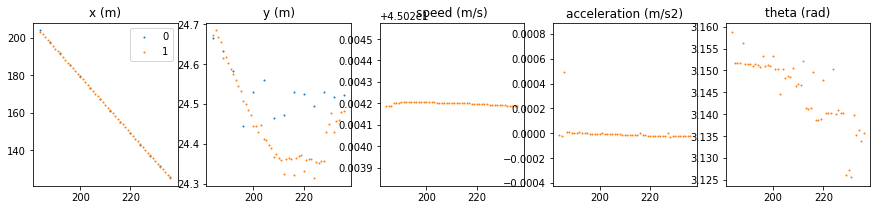

In [38]:
import utils
importlib.reload(utils)
utils.dashboard([pre, post])

In [219]:
import numpy.linalg as LA
pts = ['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = np.array(pre[pts])
# Yre = np.array(post[pts])
lam1 = 1
xs = Y1[:,[0,2,4,6]][notNan,:]-Yre[:,[0,2,4,6]][notNan,:]
ys = Y1[:,[1,3,5,7]][notNan,:]-Yre[:,[1,3,5,7]][notNan,:]
c1 = lam1*(0.99*np.sum(LA.norm(xs,axis=1))+0.01*np.sum(LA.norm(ys,axis=1)))/np.count_nonzero(notNan)
print(c1)

0.94263117259361


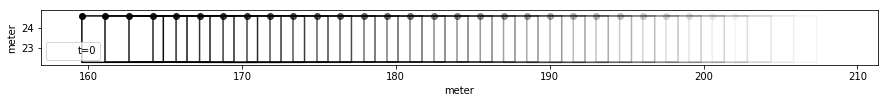

In [215]:
utils.plot_track(Yre)

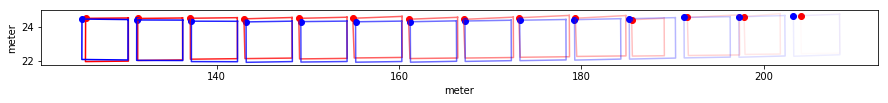

In [39]:
# pre = utils.reorder_points(pre)
utils.plot_track_compare(pre, post[::4])
# utils.plot_track_df(pre)

In [146]:
def generate(w,l,x0, y0, theta,v):
    # extract results
    # unpack variables
    N = len(theta)
    dt = [1/30]*N
    
    vx = v*cos(theta)
    vy = v*sin(theta)

    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = x0
    y[0] = y0
    for k in range(0,N-1):
        x[k+1] = x[k] + vx[k]*dt[k]
        y[k+1] = y[k] + vy[k]*dt[k]

    # compute positions
    xa = x + w/2*sin(theta)
    ya = y - w/2*cos(theta)
    xb = xa + l*cos(theta)
    yb = ya + l*sin(theta)
    xc = xb - w*sin(theta)
    yc = yb + w*cos(theta)
    xd = xa - w*sin(theta)
    yd = ya + w*cos(theta)
    Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1)
    return Yre


In [ ]:
# read & rectify each camera df individually
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4/')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

# df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv") and file.startswith('p1c6'):
            
            # ... reading ...
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('reading ',camera_id,'...')
            
            # ... preprocessing ...
            df = utils.preprocess(file_name, tform_path)
            df = df.assign(camera=camera_id)
            df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
        
            # ... rectifying ...
            df = opt.rectify(df)
            
            # ... post processing ...
            dfpp = utils.post_process(df)
            dfpp_img = utils.road_to_img(dfpp, tform_path)
            
            # ... saving ...
            new_name = 'rectified_' + camera_id +'.csv'
            dfpp_img.to_csv(new_name)
    break

In [ ]:
# plot 
import utils
importlib.reload(utils)
D = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D,15,5)

In [ ]:
fig, ax = plt.subplots()
# plt.xlim(xmin, xmax)
# plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=cm.rainbow(np.linspace(0,1,5))

# frameSnap = np.array(group[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
for carid, track in tracks.items():
    frameSnap = track
    c = carColors[carid%5]
    for j in range(len(frameSnap)):  # draw one vehicle onto the plot
    #     carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
        coord = frameSnap[j,0:8]   # Finding the coordinates of the car
        if (np.isnan(coord).any()):
            print('nan')
            continue
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs,ys,c=c,label=carid if j==0 else '')
        #     plt.text(frameSnap[j,1], frameSnap[j,2], carID)
#     plt.legend()
